In [94]:
import sys
import os
from pathlib import Path
import cv2
import nibabel as nib
import pydicom
import pylibjpeg
from pydicom.data import get_testdata_files
from pydicom.pixel_data_handlers.util import apply_voi_lut

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, losses
from keras.layers import Dense, Dropout, Input

In [2]:
submission = pd.read_csv('sample_submission.csv')
submission

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


In [3]:
test = pd.read_csv('test.csv')
test

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [4]:
train_bounding_boxes = pd.read_csv('train_bounding_boxes.csv')
train_bounding_boxes

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
...,...,...,...,...,...,...
7212,1.2.826.0.1.3680043.9940,297.23186,115.53983,85.18228,66.52623,140
7213,1.2.826.0.1.3680043.9940,298.00000,117.00000,86.00000,61.00000,141
7214,1.2.826.0.1.3680043.9940,298.00000,119.00000,87.00000,58.00000,142
7215,1.2.826.0.1.3680043.9940,299.00000,120.00000,89.00000,56.00000,143


In [5]:
paths = Path('./train_images')

train = pd.read_csv('train.csv')
train['total_fracture'] = train[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].sum(axis=1)

train['dcm_path'] = train['StudyInstanceUID'].map(lambda x: paths/x)
train['num_slices'] = train['dcm_path'].map(lambda path: len(list(path.glob('*'))))

train['nii_path'] = None
for file in list(Path('./segmentations').glob('*')):
    train.loc[train['StudyInstanceUID']==file.name[:-4],'nii_path'] = file
    
train

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,total_fracture,dcm_path,num_slices,nii_path
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,2,train_images\1.2.826.0.1.3680043.6200,243,None
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,1,train_images\1.2.826.0.1.3680043.27262,406,None
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,1,train_images\1.2.826.0.1.3680043.21561,385,None
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,0,train_images\1.2.826.0.1.3680043.12351,501,None
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,1,train_images\1.2.826.0.1.3680043.1363,199,segmentations\1.2.826.0.1.3680043.1363.nii
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1,3,train_images\1.2.826.0.1.3680043.21684,533,None
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1,1,train_images\1.2.826.0.1.3680043.4786,291,None
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0,0,train_images\1.2.826.0.1.3680043.14341,381,None
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0,0,train_images\1.2.826.0.1.3680043.12053,279,None


### dcm files

In [6]:
pydicom.dcmread('./train_images/1.2.826.0.1.3680043.10051/133.dcm')

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10051.1.133
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10051.1.133
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183726.723137'
(0010, 0010) Patient's Name                      PN: '10051'
(0010, 0020) Patient ID                          LO: '10051'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

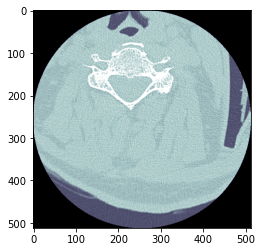

In [123]:
filename =('./train_images/1.2.826.0.1.3680043.10051/133.dcm')
dcm = pydicom.dcmread(filename)
image = apply_voi_lut(dcm.pixel_array, dcm)
plt.imshow(image, cmap = 'bone')

In [9]:
slice_points = {}
for index, row in train_bounding_boxes.iterrows():
    if not row.StudyInstanceUID in slice_points:
        slice_points[row.StudyInstanceUID] = {}
    slice_points[row.StudyInstanceUID][row.slice_number] = {
        'x1' : row.x + row.width,
        'x2' : row.x - row.width,
        'y1' : row.y + row.height,
        'y2' : row.y - row.height
    } 

In [178]:
def get_dcm_images(path):
    paths = list(path.glob('*'))
    paths.sort(key= lambda x: int(x.stem))
    dcms = [pydicom.dcmread(dcm) for dcm in paths]
    images = [apply_voi_lut(dcm.pixel_array, dcm) for dcm in dcms]
    return images

### nii files
*Only 2018 studies has nii files*

(429, 512, 512)
[0. 2. 3.]


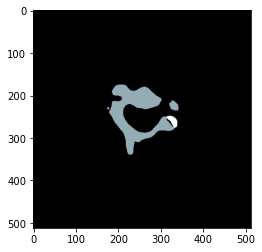

In [187]:
test_nii = list(Path('./segmentations').glob('*'))[0]
file = nib.load(test_nii)
segmentations = file.get_fdata()[::-1,::-1,::].transpose(2,1,0)
print(segmentations.shape)
plt.imshow(segmentations[250,:,:], cmap='bone')
print(np.unique(segmentations[250,:,:]))

In [55]:
def get_nii_segments(path):
    segments = None
    if not path == None:
        nii = nib.load(path)
        segments = nii.get_fdata()[::,::-1,::-1].transpose(2,1,0)
    return segments

### slices

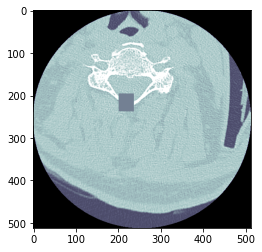

In [188]:
test_UID = '1.2.826.0.1.3680043.10051'
test_slice_number = 133
test_row = train_bounding_boxes.iloc[0]
test_points = {
    'x1' : test_row.x + test_row.width,
    'x2' : test_row.x - test_row.width,
    'y1' : test_row.y + test_row.height,
    'y2' : test_row.y - test_row.height
}

start_point = (int(test_points['x1']), int(test_points['y1']))
end_point = (int(test_points['x2']), int(test_points['y2']))
color = (0,0,0)

image = cv2.rectangle(image, start_point, end_point, color, -1)
plt.imshow(image, cmap = 'bone')

In [189]:
slice_points = {}
for index, row in train_bounding_boxes.iterrows():
    if not row.StudyInstanceUID in slice_points:
        slice_points[row.StudyInstanceUID] = {}
    slice_points[row.StudyInstanceUID][row.slice_number] = {
        'x1' : row.x + row.width,
        'x2' : row.x - row.width,
        'y1' : row.y + row.height,
        'y2' : row.y - row.height
    } 

In [60]:
train_with_segments = train[train['nii_path'].notnull()].reset_index()
train_with_segments

,index,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,total_fracture,dcm_path,num_slices,nii_path
0,4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,1,train_images\1.2.826.0.1.3680043.1363,199,segmentations\1.2.826.0.1.3680043.1363.nii
1,41,1.2.826.0.1.3680043.25704,0,0,0,0,0,0,0,0,0,train_images\1.2.826.0.1.3680043.25704,257,segmentations\1.2.826.0.1.3680043.25704.nii
2,53,1.2.826.0.1.3680043.20647,0,0,0,0,0,0,0,0,0,train_images\1.2.826.0.1.3680043.20647,263,segmentations\1.2.826.0.1.3680043.20647.nii
3,60,1.2.826.0.1.3680043.31077,1,0,0,1,1,1,1,0,4,train_images\1.2.826.0.1.3680043.31077,672,segmentations\1.2.826.0.1.3680043.31077.nii
4,99,1.2.826.0.1.3680043.17960,0,0,0,0,0,0,0,0,0,train_images\1.2.826.0.1.3680043.17960,271,segmentations\1.2.826.0.1.3680043.17960.nii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,1910,1.2.826.0.1.3680043.32071,1,0,1,0,1,0,1,1,4,train_images\1.2.826.0.1.3680043.32071,263,segmentations\1.2.826.0.1.3680043.32071.nii
83,1932,1.2.826.0.1.3680043.30524,1,0,0,0,0,0,1,1,2,train_images\1.2.826.0.1.3680043.30524,240,segmentations\1.2.826.0.1.3680043.30524.nii
84,1945,1.2.826.0.1.3680043.28025,0,0,0,0,0,0,0,0,0,train_images\1.2.826.0.1.3680043.28025,481,segmentations\1.2.826.0.1.3680043.28025.nii
85,1948,1.2.826.0.1.3680043.21321,1,1,1,1,0,0,0,1,4,train_images\1.2.826.0.1.3680043.21321,673,segmentations\1.2.826.0.1.3680043.21321.nii


In [180]:
sample_idx = 0
dcm_images = get_dcm_images(train_with_segments['dcm_path'][sample_idx])
nii_segments = get_nii_segments(train_with_segments['nii_path'][sample_idx])
print((len(dcm_images), *dcm_images[0].shape), nii_segments.shape)

(199, 512, 512) (199, 512, 512)


In [181]:
def check_reverse_required(path):
    paths = list(path.glob('*'))
    paths.sort(key=lambda x:int(x.stem))
    z_first = pydicom.dcmread(paths[0]).get("ImagePositionPatient")[-1]
    z_last = pydicom.dcmread(paths[-1]).get("ImagePositionPatient")[-1]
    if z_last < z_first:
        return False
    return True

In [182]:
train['reverse_required'] = train['dcm_path'].apply(check_reverse_required)

In [183]:
train['reverse_required'].value_counts()

False    1822
True      197
Name: reverse_required, dtype: int64

In [184]:
print(list(train[train['reverse_required']==True].index))

[1, 4, 27, 30, 39, 47, 48, 66, 72, 80, 136, 151, 169, 176, 194, 195, 201, 209, 214, 232, 235, 243, 258, 262, 267, 281, 297, 332, 334, 336, 338, 339, 344, 372, 386, 391, 402, 407, 419, 421, 428, 435, 455, 467, 476, 488, 490, 502, 507, 510, 517, 534, 543, 558, 561, 567, 569, 572, 574, 588, 600, 606, 617, 633, 635, 640, 671, 680, 685, 702, 716, 721, 756, 777, 779, 787, 802, 803, 831, 832, 837, 840, 846, 870, 886, 888, 897, 906, 912, 913, 928, 937, 941, 943, 958, 978, 995, 999, 1011, 1017, 1022, 1024, 1041, 1055, 1056, 1074, 1075, 1086, 1094, 1102, 1104, 1108, 1120, 1135, 1139, 1143, 1158, 1169, 1197, 1223, 1227, 1238, 1256, 1275, 1284, 1311, 1333, 1340, 1347, 1383, 1384, 1394, 1396, 1408, 1409, 1413, 1432, 1438, 1445, 1468, 1482, 1485, 1487, 1488, 1495, 1497, 1498, 1505, 1510, 1514, 1525, 1530, 1531, 1532, 1539, 1555, 1567, 1584, 1588, 1595, 1608, 1615, 1637, 1639, 1643, 1665, 1667, 1675, 1683, 1702, 1712, 1718, 1726, 1764, 1773, 1797, 1823, 1841, 1842, 1856, 1861, 1868, 1873, 1884, 1910,

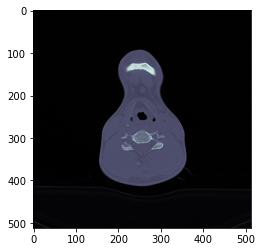

In [79]:
plt.imshow(dcm_images[::-1][18], cmap='bone')

### sagittal view

StudyInstanceUID                      1.2.826.0.1.3680043.1363
patient_overall                                              1
C1                                                           0
C2                                                           0
C3                                                           0
C4                                                           0
C5                                                           1
C6                                                           0
C7                                                           0
total_fracture                                               1
dcm_path                 train_images\1.2.826.0.1.3680043.1363
num_slices                                                 199
nii_path            segmentations\1.2.826.0.1.3680043.1363.nii
reverse_required                                          True
Name: 4, dtype: object


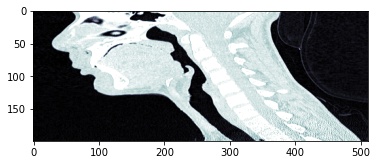

In [179]:
print(train.loc[4,:])
dcm_images = get_dcm_images(train['dcm_path'][4]) # 0 fractures
dcm_np = np.array(dcm_images)
if train['reverse_required'][4] == True:
    dcm_np = dcm_np[::-1]
saggital_view = dcm_np[:,:,256]
plt.imshow(saggital_view, cmap='bone')